В этом ноутбуке исследуется качество четырех моделей (GaussianCopula, CTGAN, CopulaGAN, TVAE) генерации синтетических данных применительно к задаче генерации синтетических профилей пользователей из датасета Netflix.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import time
import itertools

import pandas as pd
import numpy as np

import pyspark.sql.types as st
import pyspark.sql.functions as sf
from pyspark import SparkConf
from pyspark.sql import SparkSession

from replay.session_handler import State
from simulator.utils import pandas_to_spark
from simulator.modules import SDVDataGenerator, evaluate_synthetic

%matplotlib inline
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

SPARK_LOCAL_DIR = '/data/home/anthony/tmp'
DATA_PATH = r'file:///home/anthony/codin/sber/data/Netflix'

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '20g')\
    .config('spark.local.dir', SPARK_LOCAL_DIR)\
    .getOrCreate()

State(spark)

22/11/01 13:24:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/01 13:24:48 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/01 13:24:49 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/11/01 13:24:49 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
22/11/01 13:24:49 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.
22/11/01 13:24:49 WARN Utils: Service 'SparkUI' could not bind on port 4043. Attempting port 4044.


# Read data

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Netflix): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [3]:
USER_PREFIX = 'user_'

SAMPLE_FRAC = 0.028

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)] +\
    [st.StructField('rating_cnt', st.IntegerType())]
)
users_df_train = spark.read.csv(f'{DATA_PATH}/train/users.csv', header=True, schema=USER_SCHEMA)

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, USER_PREFIX + c)

users_df_train = users_df_train.cache()
users_df_train.count()

22/10/26 19:56:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


365792

# Fit Gaussian Copula

Обучаем генераторы на сэмплах (sample(0.028) -- примерно 10 тыс. пользователей) с целью экономии времени в данном ноутбуке. Вообще пробовали и на больших кусках, но на качество особенно не влияло.

In [5]:
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

start = time.time()
generator_1.fit(users_df_train.sample(SAMPLE_FRAC).drop('user_idx'))
print(f'Fitting of GaussianCopula: {time.time() - start}')

generator_1.save_model('../bin/netflix_users_gaussiancopula.pkl')

Fitting of GaussianCopula: 11.994847059249878


# Gaussian Copula data quality

Качество моделей генерации синтетических данных оценивается с помощью четырех метрик:

-- Logistic Detection

-- SVC Detection

-- KS Test

-- KL Divergence

In [6]:
real_users = users_df_train.sample(SAMPLE_FRAC)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

print(gen_score)

gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'GaussianCopula'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df = pd.DataFrame()
gen_result_df = pd.concat([gen_result_df, gen_result])

gen_result_df

22/10/26 19:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1024.5 KiB
22/10/26 19:56:27 WARN DAGScheduler: Broadcasting large task binary with size 1026.0 KiB


{'LogisticDetection': 0.6821210611814339, 'SVCDetection': 0.021976502967502864, 'KSTest': 0.8305225829550065, 'ContinuousKLDivergence': 0.8108841820778441}


,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.682121,LogisticDetection
1,GaussianCopula,0.021977,SVCDetection
2,GaussianCopula,0.830523,KSTest
3,GaussianCopula,0.810884,ContinuousKLDivergence


# Fit CTGAN

In [7]:
generator_2 = SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='ctgan',
    parallelization_level=4,
    device_name='cuda:0',
    seed=1234
)

start = time.time()
generator_2.fit(users_df_train.sample(SAMPLE_FRAC).drop('user_idx'))
print(f'Fitting of CTGAN: {time.time() - start}')

generator_2.save_model('../bin/netflix_users_ctgan.pkl')

Fitting of CTGAN: 4182.783979892731


# CTGAN data quality

In [8]:
real_users = users_df_train.sample(SAMPLE_FRAC)
syn_users = generator_2.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

print(gen_score)

gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CTGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

{'LogisticDetection': 0.04500146180789777, 'SVCDetection': 0.0017683313257762512, 'KSTest': 0.7628679797529644, 'ContinuousKLDivergence': 0.8135014787092766}


,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.682121,LogisticDetection
1,GaussianCopula,0.021977,SVCDetection
2,GaussianCopula,0.830523,KSTest
3,GaussianCopula,0.810884,ContinuousKLDivergence
0,CTGAN,0.045001,LogisticDetection
1,CTGAN,0.001768,SVCDetection
2,CTGAN,0.762868,KSTest
3,CTGAN,0.813501,ContinuousKLDivergence


# Fit CopulaGAN

In [9]:
generator_3= SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='copulagan',
    parallelization_level=4,
    device_name='cuda:0',
    seed=1234
)

start = time.time()
generator_3.fit(users_df_train.sample(SAMPLE_FRAC).drop('user_idx'))
print(f'Fitting of CopulaGAN: {time.time() - start}')

generator_3.save_model('../bin/netflix_users_copulagan.pkl')

Fitting of CopulaGAN: 4239.662142276764


# CopulaGAN data quality

In [10]:
real_users = users_df_train.sample(SAMPLE_FRAC)
syn_users = generator_3.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

print(gen_score)

gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'CopulaGAN'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

{'LogisticDetection': 0.07890966421522039, 'SVCDetection': 0.002782511108272545, 'KSTest': 0.7953350546581981, 'ContinuousKLDivergence': 0.8855633592265514}


,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.682121,LogisticDetection
1,GaussianCopula,0.021977,SVCDetection
2,GaussianCopula,0.830523,KSTest
3,GaussianCopula,0.810884,ContinuousKLDivergence
0,CTGAN,0.045001,LogisticDetection
1,CTGAN,0.001768,SVCDetection
2,CTGAN,0.762868,KSTest
3,CTGAN,0.813501,ContinuousKLDivergence
0,CopulaGAN,0.078910,LogisticDetection
1,CopulaGAN,0.002783,SVCDetection


# Fit TVAE

In [11]:
generator_4= SDVDataGenerator(
    label='synth',
    id_column_name='user_idx',
    model_name='tvae',
    parallelization_level=4,
    device_name='cuda:0',
    seed=1234
)

start = time.time()
generator_4.fit(users_df_train.sample(SAMPLE_FRAC).drop('user_idx'))
print(f'Fitting of TVAE: {time.time() - start}')

generator_4.save_model('../bin/netflix_users_tvae.pkl')

Fitting of TVAE: 1510.1700036525726


# TVAE data quality

In [12]:
real_users = users_df_train.sample(SAMPLE_FRAC)
syn_users = generator_4.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_idx'),
    real_users.drop('user_idx')
)

print(gen_score)

gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'TVAE'
gen_result['Metric_score'] = [v for k, v in gen_score.items()]
gen_result['Metric_name'] = [k for k, v in gen_score.items()]

gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

{'LogisticDetection': 0.4926066484633065, 'SVCDetection': 0.21755858788542637, 'KSTest': 0.9231843048722572, 'ContinuousKLDivergence': 0.9620518529886164}


,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.682121,LogisticDetection
1,GaussianCopula,0.021977,SVCDetection
2,GaussianCopula,0.830523,KSTest
3,GaussianCopula,0.810884,ContinuousKLDivergence
0,CTGAN,0.045001,LogisticDetection
1,CTGAN,0.001768,SVCDetection
2,CTGAN,0.762868,KSTest
3,CTGAN,0.813501,ContinuousKLDivergence
0,CopulaGAN,0.078910,LogisticDetection
1,CopulaGAN,0.002783,SVCDetection


# Baseline quality

В качестве бейзлайна возьмем синтетические данные, сгенерированные из многомерного нормального распределения со вектором средних, равных среднему значению признака в исходных данных, и диагональной ковариационной матрицей, элементы диагонали которой равны стандартному отклонению признака в исходных данных.

In [13]:
means = users_df_train.toPandas().drop(columns=['user_idx']).mean().values
stds = users_df_train.toPandas().drop(columns=['user_idx']).std().values
cov_m = np.diag(stds)

real_users = users_df_train.sample(SAMPLE_FRAC)
rand_arr = np.random.multivariate_normal(means, cov_m, users_df_train.sample(0.028).count())
users_df_baseline = pd.DataFrame(data=rand_arr, columns=users_df_train.columns[1:])
users_df_baseline = pandas_to_spark(users_df_baseline, spark_session=spark)

In [14]:
baseline_score = evaluate_synthetic(
    users_df_baseline,
    real_users.drop('user_idx')
)

print(baseline_score)

gen_result = pd.DataFrame(index = np.arange(4))
gen_result['Model_name'] = 'Baseline'
gen_result['Metric_score'] = [v for k, v in baseline_score.items()]
gen_result['Metric_name'] = [k for k, v in baseline_score.items()]

gen_result_df = pd.concat([gen_result_df, gen_result])
gen_result_df

22/10/26 23:14:45 WARN TaskSetManager: Stage 34 contains a task of very large size (2725 KiB). The maximum recommended task size is 1000 KiB.


{'LogisticDetection': 0.9877534745902492, 'SVCDetection': 0.0004437796000477112, 'KSTest': 0.6540336283039678, 'ContinuousKLDivergence': 0.2021728966120978}


,Model_name,Metric_score,Metric_name
0,GaussianCopula,0.682121,LogisticDetection
1,GaussianCopula,0.021977,SVCDetection
2,GaussianCopula,0.830523,KSTest
3,GaussianCopula,0.810884,ContinuousKLDivergence
0,CTGAN,0.045001,LogisticDetection
1,CTGAN,0.001768,SVCDetection
2,CTGAN,0.762868,KSTest
3,CTGAN,0.813501,ContinuousKLDivergence
0,CopulaGAN,0.078910,LogisticDetection
1,CopulaGAN,0.002783,SVCDetection


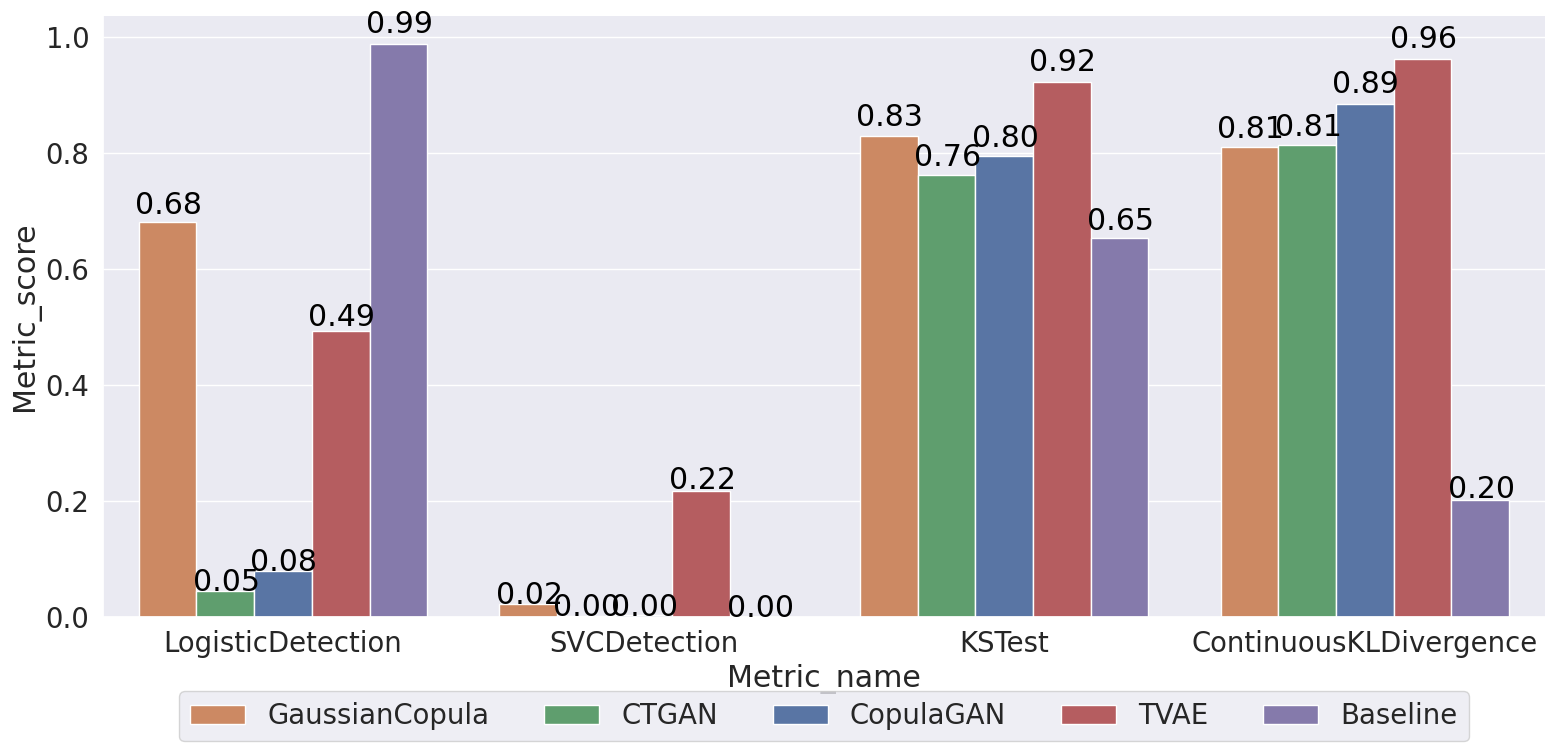

In [15]:
rcParams['figure.figsize'] = (3, 3)
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
sns.set(font_scale=1.8)  # crazy big
plot = sns.catplot(
    data=gen_result_df, x="Metric_name", y="Metric_score",
    hue="Model_name", kind="bar", aspect=2, height=8,
    palette=["C1", "C2", "C0", "C3", "C4"], legend=False
)
ax = plot.facet_axis(0,0)
def create_hist_values(df):
    model_names = df['Model_name'].unique()
    metric_names = df["Metric_name"].unique()
    hist_values = []
    for model, metric in itertools.product(model_names, metric_names):
        hist_values.append(df[(df['Model_name'] == model) & (df['Metric_name'] == metric)]['Metric_score'].values[0])
    return hist_values
hist_val = create_hist_values(gen_result_df)
for (p, val) in zip(ax.patches, hist_val):
    ax.text(p.get_x() - 0.01, 
            p.get_height() * 1.02, 
           '{:1.2f}'.format(val),   
            color='black', 
            rotation='horizontal', 
            size='medium')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, ncol=5)
plt.tight_layout()

Оказалось, что синтетические данные, сгенерированные из многомерногог нормального распределения, не отличимы от исходных логистической регрессией. По остальным метрикам качество бейзлайна ниже (или такое же), как у остальных моделей.

В целом, качество моделей генерации кажется недостаточно высоким с точки зрения метрик LogisticDetection и SVCDetection. Кроме того, все модели на нейронных сетях требуют достаточно много времени на обучение (на это влияет размерность профилей пользователей, 301). Для дальнейшей работы было решено генерировать эмбеддинги профилей пользователей. Экспериментальное исследование эмбеддингов и их влияния на качество генерации синтетики представлено в ноутбуке netflix_embeddings.ipynb.